In [1]:
# Import required general libraries
#
import matplotlib.pyplot as plt # library for plotting
import matplotlib
matplotlib.use('Qt5Agg')
# matplotlib.pyplot.ion()

import mne # library for EEG data analysis

import numpy as np # library for manging numerical data 

import os # library for managing directories

from PyQt5.QtWidgets import QFileDialog # library for creating dialogue windows

import plotly.graph_objs as go # library for graphic objects

import TECAPy_tools # library of user-defined functions




In [2]:
# define the main data folder
dir_base= QFileDialog.getExistingDirectory(None,'select dir','./', QFileDialog.ShowDirsOnly);
dir_base


'C:/LAVORO/PYTHON/DATA/Healthy'

In [3]:
# Input from user required: define the file (subject/session) to be analyzed
sub='sub1_H'


In [4]:
# automatically define a path
fname_vhdr=os.path.join(dir_base,'raw_orig',sub,sub+'.vhdr')
fname_vhdr

'C:/LAVORO/PYTHON/DATA/Healthy\\raw_orig\\sub1_H\\sub1_H.vhdr'

In [6]:
# Read continuous original data in proprietary format and save them as .fif files
raw = mne.io.read_raw_brainvision(fname_vhdr, eog=['VEOG','HEOG'], preload=True)#
# Create the EEG layout montage by associating channel names with standard 10-20 locations
# builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
raw.rename_channels({'AF7':'AFz', 'AF8':'FCz'})
raw=raw.set_montage('easycap-M1', verbose=True)

Extracting parameters from C:/LAVORO/PYTHON/DATA/Healthy\raw_orig\sub1_H\sub1_H.vhdr...
Setting channel info structure...
Reading 0 ... 3446699  =      0.000 ...   689.340 secs...


C:\Users\silvia.casarotto\AppData\Local\Temp\ipykernel_19864\1872376048.py:2: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['VEOG', 'HEOG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(fname_vhdr, eog=['VEOG','HEOG'], preload=True)#


In [15]:
# optional - plot continuous raw data to check what's inside the loaded file
raw.plot(n_channels=raw.info['nchan'])

Channels marked as bad:
none


In [8]:
#find markers within the raw data file

events, event_id = mne.events_from_annotations(raw, verbose=False)
# "events" is an array with 3 columns: sample, 0, code
# "event_id" is a dictionary indicating the correspondence between markers' name and code

print(event_id)

{'DC Correction/': 10001, 'New Segment/': 99999, 'Response/R128': 1128}


In [9]:
# counting how many markers per type
event_types,counts= np.unique(events[:,2], return_counts=True)
print(event_types)
print(counts)

[ 1128 10001 99999]
[300   1   1]


In [10]:
# first pre-processing step: removing the TMS pulse artifact

# Input from user required: define the TMS code
TMScode=1128

# identify TMS markers
events=events[np.where(events[:,2]==TMScode)[0],:] 

In [14]:
events[10,:]

array([217160,      0,   1128])

In [16]:
# apply the function that removes the TMS pulse artifact 

raw=TECAPy_tools.tms_pulse_removal_init(raw,raw.info['sfreq'],events[:,0])

# function help
# tms_pulse_removal_init(raw,sfreq,events_sample,window=(-0.002, 0.005),smooth_window=(-0.002, 0.002),span=2)

# inputs "raw", "sfreq", "events_sample" are mandatory
# inputs "window", "smooth_window", "span" have default values
    
# "window" is the time window (in seconds) around the pulse to be cut

# "smooth_window" is time window (in seconds) around the cut extremes to be smoothed by moving average 

# "span" is the half-length (in samples) of the moving average filter 
# (e.g., 2 means that 5 samples overall are used, i.e., 2 before and 2 after the current sample)




In [18]:
# optional - plot continuous raw data to check whether the pulse artifact has been removed
raw.plot(n_channels=raw.info['nchan'],scalings={'eog':50e-6})

In [19]:
# create a temporary epoch file 
# after in-place filtering of raw data with a narrow band-pass filter

epochs_tmp = mne.Epochs(
    raw.copy().filter(l_freq=1,
                      h_freq=45,
                      method = 'iir',
                      iir_params = dict(order=3, 
                                        ftype='butter',
                                        phase='zero-double',
                                        btype='bandpass'),
                      verbose=True),
    events,
    tmin=-0.8, 
    tmax=0.8,
    baseline=None,
    preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB

Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 300 events and 8001 original time points ...
0 bad epochs dropped


In [20]:
# downsample of temporary epochs data for plotting
#Input from user required: new sampling rate
newrate=500
#resample
epochs_tmp.resample(sfreq = newrate)

<Epochs |  300 events (all good), -0.8 - 0.798 sec, baseline off, ~117.3 MB, data loaded,
 '1128': 300>

In [21]:
# plot epochs for channels and trials rejection
epochs_tmp.plot(picks='all',
                n_epochs=3,
                n_channels=raw.info['nchan'],
                block=True,use_opengl=True, scalings={'eog':50e-6})

Using pyopengl with version 3.1.6
Channels marked as bad:
none
Dropped 11 epochs: 26, 42, 43, 77, 78, 92, 156, 168, 240, 287, 288
The following epochs were marked as bad and are dropped:
[26, 42, 43, 77, 78, 92, 156, 168, 240, 287, 288]
Channels marked as bad:
['TP10']


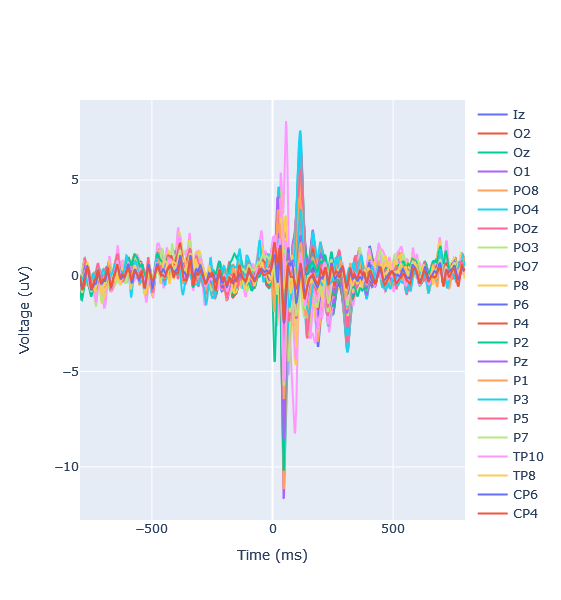

In [22]:
# plot evoked data in butterfly mode to search for additional bad channels 
TECAPy_tools.plotly_evoked(epochs_tmp.average(), tlims=(-0.8, 0.8))

In [23]:
# insert additional bad channels below (e.g. add_bad_ch=['FP1', 'P4', 'PO7'])
# remember to run add_bad_ch=[] in case there are no additional bad channels
add_bad_ch=[]

In [24]:
# broad band-pass filter applied to raw data
raw.filter(l_freq=1,
           h_freq=250,
           method = 'iir',
           iir_params = dict(order=3, ftype='butter',phase='zero-double',btype='bandpass'),
           verbose=True)

# epoching raw data after broad band-pass filtering
epochs = mne.Epochs(raw,events,tmin=-0.8, tmax=0.8,baseline=None,preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2.5e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 250.00 Hz: -6.02, -6.02 dB

Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 300 events and 8001 original time points ...
0 bad epochs dropped


In [25]:
# report bad channels and bad trials information from epochs_tmp to epochs 
epochs=epochs[epochs_tmp.selection]
epochs.info['bads'] = epochs_tmp.info['bads']+add_bad_ch

In [26]:
# generate automatically a filename for saving epoch data
fname_epo=os.path.join(dir_base,'epo',sub+'-epo.fif')
fname_epo

'C:/LAVORO/PYTHON/DATA/Healthy\\epo\\sub1_H-epo.fif'

In [27]:
# save epoch data
epochs.save(fname_epo)

In [ ]:
# optional - load an epochs file
# fname_epo,_ = QFileDialog.getOpenFileName(None,'load file',dir_base,'*-epo.fif');
# epochs = mne.read_epochs(fname_epo)

In [28]:
# keeping eeg-channels only and re-referencing to the average reference
bad_ch_tmp=len(epochs.info['bads'])
epochs.interpolate_bads()
epochs = epochs.pick('eeg') # Pick only eeg channels
epochs = epochs.set_eeg_reference('average')#ch_type

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 1 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [29]:
# downsample to speed-up further analysis steps (e.g., ICA, ...)
# Input from user required: new sampling rate
newrate=1000
# Resample
epochs = epochs.resample(sfreq = newrate)

In [33]:
# find the maximum number of independent components
# as the number of good channels - 1 because of average referencing

n_components = len(epochs.ch_names) - bad_ch_tmp - 1
n_components



60

In [32]:
bad_ch_tmp=1

In [34]:
# set ICA parameters
ica=mne.preprocessing.ICA(n_components=n_components, method='fastica',verbose=True)

In [35]:
# perform ICA decomposition
ica=ica.fit(epochs)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by number: 60 components


C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.



Fitting ICA took 375.2s.


In [36]:
# generate automatically a filename for saving ica decomposition
fname_ica=os.path.join(dir_base,'ica',sub+'-ica.fif')
fname_ica

'C:/LAVORO/PYTHON/DATA/Healthy\\ica\\sub1_H-ica.fif'

In [37]:
# save ica decomposition
ica.save(fname_ica)

Writing ICA solution to C:\LAVORO\PYTHON\DATA\Healthy\ica\sub1_H-ica.fif...


<ICA | epochs decomposition, method: fastica (fit in 1000 iterations on 462400 samples), 60 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>

In [3]:
# optional - load an epochs file
fname_epo,_ = QFileDialog.getOpenFileName(None,'load file',dir_base,'*-epo.fif');
epochs = mne.read_epochs(fname_epo)

# keeping eeg-channels only and re-referencing to the average reference
bad_ch_tmp=len(epochs.info['bads'])
epochs.interpolate_bads()
epochs = epochs.pick('eeg') # Pick only eeg channels
epochs = epochs.set_eeg_reference('average')#ch_type

# downsample to speed-up further analysis steps (e.g., ICA, ...)
newrate=1000
epochs = epochs.resample(sfreq = newrate)

# find the maximum number of independent components
# as the number of good channels - 1 because of average referencing

n_components = len(epochs.ch_names) - bad_ch_tmp - 1
n_components

# load an ica file
fname_ica,_ = QFileDialog.getOpenFileName(None,'load file',dir_base,'*-ica.fif');
ica=mne.preprocessing.read_ica(fname_ica)

Reading C:\LAVORO\PYTHON\DATA\Healthy\Madalina_Bucur_19Nov2024\epo\Malina_Bucur_19nov2024_0003-epo.fif ...
    Found the data of interest:
        t =    -800.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Reading C:/LAVORO/PYTHON/DATA/Healthy/Madalina_Bucur_19Nov2024/ica/Malina_Bucur_19nov2024_0003-ica.fif ...
Now restoring ICA solution ...
Ready.


In [38]:
# Plot IC time course
matplotlib.figure.Figure_ICtimecourse=ica.plot_sources(epochs)

Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
# Open ICA GUI to select and remove artefactual components
matplotlib.pyplot.ion()
ica = TECAPy_tools.ICApp(ica, epochs)

Applying baseline correction (mode: mean)


TypeError: 'Axes' object is not iterable

In [43]:
ica.exclude=[0,1,2,3,5,7,8,9,13,15,17,20,23,24,28]

In [44]:
# Apply ICA to the epochs data
epochs_ica=ica.apply(epochs.copy(), exclude=ica.exclude)

Applying ICA to Epochs instance
    Transforming to ICA space (60 components)
    Zeroing out 15 ICA components
    Projecting back using 62 PCA components


In [13]:
ica.exclude

[0, 1, 5, 11, 12, 14, 15, 18, 19]

In [45]:
# Filtering & Resampling the data after ICA
epochs_ica.filter(l_freq=None,
                      h_freq=45,
                      method = 'iir',
                      iir_params = dict(order=3, 
                                        ftype='butter',
                                        phase='zero-double',
                                        btype='bandpass'),
                      verbose=True)

newrate=500 #choose the desired sampling rate
epochs_ica_dws=epochs_ica.resample(sfreq = newrate)

Setting up low-pass filter at 45 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 6 (effective, after forward-backward)
- Cutoff at 45.00 Hz: -6.02 dB



In [16]:
# Interpoling bad channels
epochs_ica_dws=epochs_ica_dws.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 1 sensors


In [46]:
#Save pre-processed epochs
fname_clean_epo=os.path.join(dir_base,'epo_clean',sub+'_clean-epo.fif')
epochs_ica_dws.save(fname_clean_epo)

In [3]:
# # # optional - Load pre-processed epochs
# fname_epo,_ = QFileDialog.getOpenFileName(None,'load file',dir_base,'*_clean-epo.fif');
# epochs_ica_dws = mne.read_epochs(fname_epo)

Reading E:\docs\sacco\Congressi\Brain_Products_Workshop\Python\data\TMS-EEG_Workshop\epo_clean\sub_02_healthy_clean-epo.fif ...
    Found the data of interest:
        t =    -800.00 ...     798.00 ms
        0 CTF compensation matrices available
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated


In [47]:
# Cropping the epochs
epochs_ica_dws=epochs_ica_dws.crop(tmin=-0.6, tmax=0.6)

In [48]:
# Plotting the evoked signal
epochs_ica_dws.average().plot()

<Figure size 640x300 with 2 Axes>

In [22]:
epochs_ica_dws.rename_channels({'AF7':'AFz', 'AF8':'FCz'})

<EpochsFIF |  217 events (all good), -0.6 - 0.6 sec, baseline off, ~61.8 MB, data loaded,
 '1128': 217>

In [24]:
epochs_ica_dws=epochs_ica_dws.set_montage('easycap-M1', verbose=True)

In [ ]:
epochs_ica_dws.copy().crop(-0.1,0.4).average().plot_topo(ylim = dict(eeg=[-5, 5]))

In [ ]:
#Save pre-processed evoked data
fname_evo=os.path.join(dir_base,'evoked',sub.split('.')[0]+'-ave.fif')
epochs_ica_dws.average().save(fname_evo)

In [ ]:
# Load pre-oricessed evoked data
fname_evo,_ = QFileDialog.getOpenFileName(None,'load file',dir_base,'*-evo.fif');
evoked = mne.read_evokeds(fname_evo)

In [4]:
matplotlib.figure.Figure_ICtimecourse=ica.plot_sources(epochs)# to plot IC time course

Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated
Using qt as 2D backend.


In [42]:
matplotlib.pyplot.ion()
matplotlib.figure.Figure_ICtopo=ica.plot_components(picks=list(np.arange(20, 30)), ch_type='eeg',
                    inst=epochs, plot_std=False, reject=None, 
                    cmap='RdBu', vlim=(None, None), cnorm=None, colorbar=False, 
                    image_args=dict(cmap='RdBu', vmin=-1, vmax=1), 
                    psd_args=dict(fmin=0, fmax=50), verbose=None,
                    )

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items ac

In [8]:
# # grafico tutte topo
[0,1,2,3,5,7,8,9,13,15,17,20,23,24,28]
picks=[3]
# matplotlib.pyplot.ion()
matplotlib.figure.Figure_ICproperty=ica.plot_properties(epochs, picks=picks, axes=None, dB=True, plot_std=False, 
                    log_scale=False, topomap_args=dict(cmap='RdBu'), image_args=dict(cmap='RdBu', vmin=-1, vmax=1),
                    psd_args=dict(fmin=0, fmax=50))
# , figsize=None, show=True, reject='auto', reject_by_annotation=True, *, verbose=None)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
217 matching events found
No baseline correction applied
0 projection items activated


KeyboardInterrupt: 

In [ ]:
# fig, axes = plt.subplots(1, 2, sharey='all', sharex='all')
# for ax, ep in zip(axes, [epochs, epochs_ica]):
#     ep.average().plot(axes=ax, show=False)
# plt.show()

In [ ]:
# ##
# curr_picks=np.arange(42)
# fig, axes = plt.subplots(1, 2, sharey='all', sharex='all')
# # prova1=epochs.copy()
# # prova2=epochs.copy()
# for ax, ep in zip(axes, [ica.apply(epochs.copy(), exclude=None), ica.apply(epochs.copy(), exclude=curr_picks)]):
#     ep.average().plot(axes=ax, show=True)
# plt.show()

In [ ]:
# # applica ICA rej comp
# newrate=1000
# epochs_ica=ica.apply(epochs.copy(), exclude=None)
# # salva
# epochs_ica.filter(l_freq=None,
#                       h_freq=45,
#                       method = 'iir',
#                       iir_params = dict(order=3, 
#                                         ftype='butter',
#                                         phase='zero-double',
#                                         btype='bandpass'),
#                       verbose=True)
# epochs_ica_dws=epochs_ica.resample(sfreq = newrate)
# #salva
# #timef
# # plot di average, allchdisplay


In [49]:
gmfp = TECAPy_tools.plot_gmfp(epochs_ica_dws)

In [50]:
# ERSP

ersp, freqs = TECAPy_tools.plot_ersp(epochs_ica_dws, 'FC1',crop_edges=False)
# ersp, freqs = TECAPy_tools.get_ersp(epochs_ica_dws, 'Oz')


Traceback (most recent call last):
  File "C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\mne\viz\evoked.py", line 163, in _topo_closed
    ax.lines.remove(line)
    ^^^^^^^^^^^^^^^
AttributeError: 'ArtistList' object has no attribute 'remove'
Traceback (most recent call last):
  File "C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\mne\viz\evoked.py", line 163, in _topo_closed
    ax.lines.remove(line)
    ^^^^^^^^^^^^^^^
AttributeError: 'ArtistList' object has no attribute 'remove'
Traceback (most recent call last):
  File "C:\prog_installati\mne-python\1.5.0_0\Lib\site-packages\matplotlib\cbook\__init__.py", line 309, in process
    func(*args, **kwargs)
  File "C:\prog_installati\mne-py